<a href="https://colab.research.google.com/github/Anfaga/TFM-BigData-DataScience-VIU/blob/main/%C3%81rboles_de_Decisi%C3%B3n_Regresi%C3%B3n_Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Carlos Andrés Falla Gaitán - TFM Máster en BigData y DataScience VIU

# DT Regression Covid-19

Aplicación de Técnicas de Aprendizaje Automático Supervisado para el Pronóstico del Número de Casos Nuevos de Covid19 en Bogotá-Colombia.

El propósito es estimar el número de casos nuevos de Coavid-19 en la ciudad de Bogotá, Colombia.

Se usará análisis de regresión con árboles de decisión (CART) con el fin de explicar el número de casos con características seleccionadas de los sectores de Salud, Ambiente, Transporte, Seguridad y Finanzas.

## Carga de Librerias

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from numpy import corrcoef, transpose, arange
from pylab import pcolor, show, colorbar, xticks, yticks

## Carga de Datos

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  

Saving Base_Covid.csv to Base_Covid.csv
User uploaded file "Base_Covid.csv" with length 21125 bytes


In [ ]:
import pandas as pd
import io
bcasos = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')),  index_col = 'fecha_caso')
bcasos.head()

,Casos,Pruebas_PCR,Casos_Salud,RT,Ocupacion_Camas,Ocupacion_UCI,Ocupacion_Crematorios,Temp_Min,Temp_Max,Pasajeros_TM,Vuelos,Trafic,Hurtos,Lesiones_Personales,TRM,TIP
fecha_caso,,,,,,,,,,,,,,,,
2020-03-01,1,0,0,1.183851,0.0,0.0,11.5,10.00,21.17,402450,0,0.0,39,116,3539.86,4.25
2020-03-02,1,0,0,2.401324,0.0,0.0,9.0,9.17,21.60,935858,0,0.0,44,59,3539.86,4.25
2020-03-03,0,0,0,1.704885,0.0,0.0,8.0,9.30,22.11,1128778,0,0.0,71,57,3512.17,4.25
2020-03-04,5,0,0,1.862228,0.0,0.0,15.0,9.57,22.29,1103128,0,0.0,66,66,3455.56,4.25
2020-03-05,5,0,0,1.988661,0.0,0.0,12.5,6.23,23.37,1086023,0,0.0,71,61,3458.45,4.25


## Análisis de Correlación

In [ ]:
import numpy as np
from scipy.stats.stats import pearsonr 
corr = [pearsonr(bcasos['Temp_Min'], bcasos['Casos'])[0],
        pearsonr(bcasos['Temp_Max'], bcasos['Casos'])[0],
        pearsonr(bcasos['Pasajeros_TM'], bcasos['Casos'])[0],
        pearsonr(bcasos['Vuelos'], bcasos['Casos'])[0],
        pearsonr(bcasos['Trafic'], bcasos['Casos'])[0],
        pearsonr(bcasos['Hurtos'], bcasos['Casos'])[0],
        pearsonr(bcasos['Lesiones_Personales'], bcasos['Casos'])[0],
        pearsonr(bcasos['TRM'], bcasos['Casos'])[0],
        pearsonr(bcasos['TIP'], bcasos['Casos'])[0]]

 
features= ('Temp_Min','Temp_Max','Pasajeros_TM','Vuelos','Trafic','Hurtos','Lesiones_Personales','TRM','TIP')
y_pos = np.arange(len(features))
 
plt.bar(y_pos, corr, align='center', alpha=0.5)
plt.xticks(y_pos, features)
plt.ylabel('Correlation')
plt.title('Correlation features vs target')

plt.show()

corr

## Modelado

### Partición del Conjunto de Datos: Training and Testing

Antes de proceder a crear los modelos para predecir vamos a dividir nuestro conjunto de datos en dos partes una para entrenamiento (tuning) y otra para test. Para ello vamos a utilizar los datos de marzo a julio 2019 para entrenamiento y agosto 2019 para pruebas.  

In [ ]:
df = bcasos[['Ocupacion_UCI','Temp_Min','Temp_Max','Pasajeros_TM','Vuelos','Trafic','Hurtos','TRM','Casos']]

features= ('Ocupacion_UCI','Temp_Min','Temp_Max','Pasajeros_TM','Vuelos','Trafic','Hurtos','TRM')

train = df.loc['2020-03-01':'2020-07-31']
test  = df.loc['2020-08-01':]

### Parametrización

Primero vamos a probar  si nuestro rendimiento mejora aumentando la profundidad evaluando con el propio conjunto de entrenamiento

No handles with labels found to put in legend.


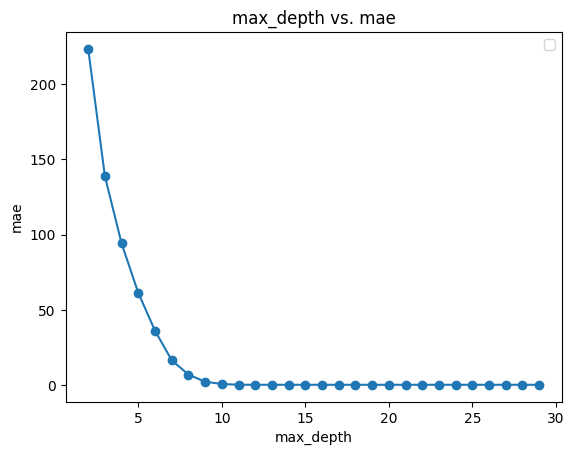

In [ ]:
# Compute the max 
mae = []
from sklearn.metrics import mean_absolute_error
for i in range(2, 30):
    regressor = DecisionTreeRegressor(max_depth=i)
    regressor.fit(train[['Ocupacion_UCI','Temp_Min','Temp_Max','Pasajeros_TM','Vuelos','Trafic','Hurtos','TRM']], train['Casos'])
    pred_values = regressor.predict(train[['Ocupacion_UCI','Temp_Min','Temp_Max','Pasajeros_TM','Vuelos','Trafic','Hurtos','TRM']])
    maev = mean_absolute_error(train['Casos'],pred_values)
    mae.append(maev)
    
#Plot mae  
plt.plot(range(2,30), mae, marker='o')
plt.xlabel('max_depth')
plt.ylabel('mae')
plt.axis('tight')
plt.legend()
plt.title("max_depth vs. mae") 
plt.show()

Para evitar este sobreaprendizaje vamos a probar a realizar **evaluación cruzada**, es decir, evaluar las parametrizaciones ante diferentes subconjuntos de entrenamiento y de test.

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
No handles with labels found to put in legend.


Min Value 345.7668817204301 (14)


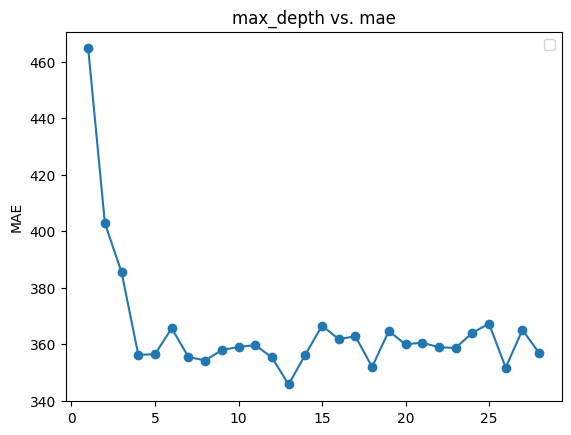

In [ ]:
# CROSS VALIDATION ANALYSIS
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import KFold
cv = KFold(n_splits = 5, shuffle = False, random_state=0) 

# reset index
train.reset_index(drop = True, inplace = True)
train.head()

total_scores = []
for i in range(2, 30):
   regressor = DecisionTreeRegressor(max_depth=i)
   fold_accuracy = []
   for train_fold, test_fold in cv.split(train):
      # División train test aleatoria
      f_train = train.loc[train_fold]
      f_test = train.loc[test_fold]
      # entrenamiento y ejecución del modelo
      regressor.fit( X = f_train.drop(['Casos'], axis=1), 
                           y = f_train['Casos'])
      y_pred = regressor.predict(X = f_test.drop(['Casos'], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test['Casos'], y_pred)
      fold_accuracy.append(mae)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


max_depth = np.argmin(total_scores) + 2
print ('Min Value ' + str(min(total_scores)) +" (" + str(max_depth) + ")")

  
plt.plot(range(1,len(total_scores)+1), total_scores, 
         marker='o')
plt.ylabel('MAE')   

plt.axis('tight')
plt.legend()
plt.title("max_depth vs. mae") 
plt.show() 



In [ ]:
total_scores

# Construcción y ejecución del modelo 



Identificada la mejor parametrización, pasamos a hacer la ejecución del modelo y a ver los resultados.

Posteriormente, vamos a ejecutar el modelo con la mejor parametrización que hayamos obtenido anteriormente 

In [ ]:
# constructor
regressor = DecisionTreeRegressor(max_depth = max_depth)
# fit and predict

regressor.fit( X = train.drop(['Casos'], axis=1), y = train['Casos'])
y_pred = regressor.predict(X = test.drop(['Casos'], axis = 1))
mae = mean_absolute_error(test['Casos'], y_pred)
print ('MAE', mae)
# round the result and cast to int
import numpy as np
res = np.rint(y_pred) # round
res = res.astype(int) # cast to int
# generate output
output = pd.DataFrame({ 'date': test.index, 'result': res})



MAE 702.3548387096774


Vamos a construir el modelo con las variables seleccionadas y a analizar la importancia de las características según el árbol de decisión

In [ ]:
regressor.fit(train[['Ocupacion_UCI','Temp_Min','Temp_Max','Pasajeros_TM','Vuelos','Trafic','Hurtos','TRM']], train['Casos'])

print ('Feature Relevances')
pd.DataFrame({'Attributes': features ,
              'Decision Tree': regressor.feature_importances_})

Feature Relevances


,Attributes,Decision Tree
0,Ocupacion_UCI,0.951591
1,Temp_Min,0.002109
2,Temp_Max,0.000751
3,Pasajeros_TM,0.021459
4,Vuelos,0.008291
5,Trafic,0.001687
6,Hurtos,0.001526
7,TRM,0.012586


Y guardamos los resultados.

In [ ]:
from google.colab import files

with open('result_DT.csv', 'w') as f:
  output.to_csv(f,  index = False)
  
files.download('result_DT.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Por último probamos visualizamos como ha quedado nuestra predicción con la realidad.

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


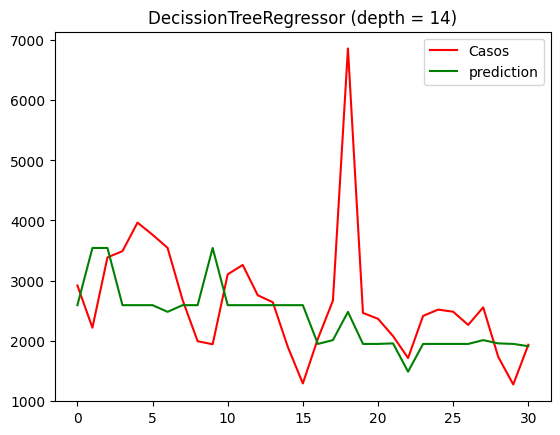

In [ ]:

from sklearn.metrics import mean_absolute_error
                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(test['Casos'].shape[0]))
plt.plot(xx, test['Casos'], c='r', label='Casos')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("DecissionTreeRegressor (depth = %i)" % max_depth)

plt.show()